In [ ]:
import kwant
import tkwant
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import tinyarray
from numpy import pi,sqrt,arccos
from kwant.wraparound import wraparound,plot_2d_bands
import scipy 
import warnings                        
warnings.filterwarnings('ignore') 

# System Creation

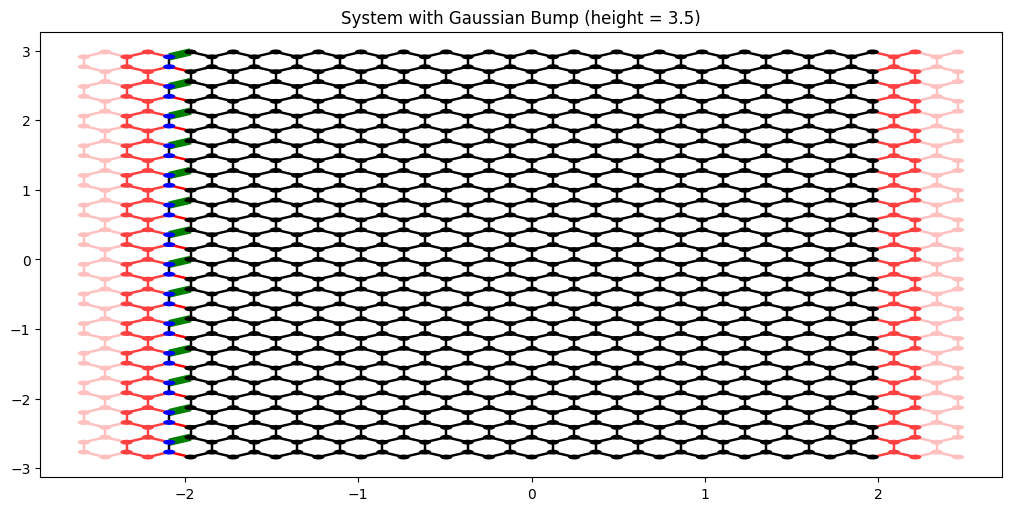

In [3]:
# ==============================================
# System Parameters
# ==============================================
Lx, Ly = 2, 3  # System dimensions
params = {
    # Physical parameters
    'Ep': 0,            # Onsite potential
    'omega': 0.01,      # Oscillation frequency
    'dh': 0.35,         # Height modulation amplitude
    'hop': -2.7,        # Hopping energy
    'lat_constant': 0.24595,  # Lattice constant
    'beta': 3.37,       # Strain parameter
    'height': 3.5,      # Bump height
    'sigma': 5,         # Bump width
    # Geometry parameters
    'a': 0.2, 'b': 0.5, 
    'center': (0, 0),   # Main bump center
    'center0': (Lx-2, 0),  # Additional bump centers
    'center1': (Lx-2, -Ly+3),
    'center2': (Lx-2, Ly-3),
    'centers': (-Lx+2, 0),
    # Physical constants
    'E': 1, 'vf': 1, 'hbar': 1
}

# ==============================================
# Lattice Definition
# ==============================================
lat = kwant.lattice.honeycomb(a=params['lat_constant'], norbs=1, name=["a", "b"])
a, b = lat.sublattices  # Sublattices for graphene

# ==============================================
# Potential and Hopping Functions
# ==============================================
def onsite(site, Ep):
    """Onsite potential term"""
    return Ep

def hopping(site1, site2, hop):
    """Unstrained hopping term"""
    return hop

def gaussian_bump(pos, height, sigma, center):
    """
    Calculate height deformation at position due to Gaussian bump
    Args:
        pos: (x,y) position
        height: Maximum bump height
        sigma: Width of bump
        center: (x,y) center of bump
    Returns:
        Height deformation dz
    """
    x, y = pos
    cx, cy = center
    r = sqrt((x-cx)**2 + (y-cy)**2)
    return height * np.exp(-r**2/(2*sigma**2))

def strained_hopping(site1, site2, beta, lat_constant, height, sigma, center, hop, time):
    """
    Strain-modified hopping term with time-dependent height modulation
    Args:
        site1, site2: Kwant sites
        beta: Strain scaling factor
        lat_constant: Lattice constant
        height: Base bump height
        sigma: Bump width
        center: Bump center position
        hop: Unstrained hopping energy
        time: Current time
    Returns:
        Modified hopping energy
    """
    # Time-dependent height modulation
    current_height = height + params['dh'] * np.sin(params['omega'] * time)
    
    # Calculate deformations at both sites
    dz1 = gaussian_bump(site1.pos, current_height, sigma, center)
    dz2 = gaussian_bump(site2.pos, current_height, sigma, center)
    
    # Calculate strained distance
    dx, dy = site1.pos[0]-site2.pos[0], site1.pos[1]-site2.pos[1]
    d_strained = sqrt(dx**2 + dy**2 + (dz1-dz2)**2)
    d_nearest = lat_constant/sqrt(3)  # Nearest-neighbor distance in graphene
    
    return hop * np.exp(-beta * (d_strained/d_nearest - 1))

# ==============================================
# System Construction
# ==============================================
def make_system(length, width, boundary):
    """
    Create strained system with leads
    Args:
        length: System length
        width: System width
        boundary: Lead type ('zigzag' or 'armchair')
    Returns:
        Dictionary containing system and lead
    """
    def rectangle(pos):
        """Define rectangular scattering region"""
        x, y = pos
        return abs(x) < length and abs(y) < width
    
    # Build scattering region
    syst = kwant.Builder()
    syst[lat.shape(rectangle, (0, 0))] = onsite
    syst[lat.neighbors(1)] = strained_hopping
    
    # Add leads for zigzag boundary
    if boundary == 'zigzag':
        sym = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
        sym.add_site_family(lat.sublattices[0], other_vectors=[(-1, 2)])
        sym.add_site_family(lat.sublattices[1], other_vectors=[(-1, 2)])
        
        def lead_shape(pos):
            """Lead shape matching system width"""
            x, y = pos
            return abs(y) < width
        
        lead = kwant.Builder(sym)
        lead[lat.shape(lead_shape, (0, 0))] = onsite
        lead[lat.neighbors(1)] = hopping
        
        # Clean up dangling bonds
        syst.eradicate_dangling()
        lead.eradicate_dangling()
        
        # Attach leads
        syst.attach_lead(lead)
        syst.attach_lead(lead.reversed())
    
    return {'system': syst, 'lead': lead}

# ==============================================
# Visualization Setup
# ==============================================
def family_color(site):
    """Color sites by sublattice"""
    return 'blue' if site.family == a else 'green'

def interface_hopping(site1, site2):
    """Color interface hoppings by direction"""
    if ((site1, site2) in interface_hoppings) or ((site2, site1) in interface_hoppings):
        return 'g' if site1.pos[0] > site2.pos[0] else 'r'
    return 'k'

def hopping_size(site1, site2):
    """Set linewidth for hoppings"""
    return 0.3 if (site1, site2) in interface_hoppings else 0.1

def site_coloring(site):
    """Color interface sites differently"""
    return 'b' if site in system.leads[0].interface else 'k'

# ==============================================
# Main Execution
# ==============================================
if __name__ == "__main__":
    # Build system
    system_dict = make_system(length=Lx, width=Ly, boundary='zigzag')
    system = system_dict['system']
    finalized_system = system.finalized()
    
    # Identify interface hoppings for visualization
    interface_hoppings = [
        hop for hop in system.hoppings() 
        if ((hop[1] in system.leads[0].interface or hop[0] in system.leads[0].interface)
        and (hop[0].pos[0] != hop[1].pos[0]))
    ]
    
    # Ensure consistent hopping directions
    interface_hoppings = [
        (site1, site2) if site1.pos[0] > site2.pos[0] else (site2, site1)
        for (site1, site2) in interface_hoppings
    ]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
    ax.set_title(f"System with Gaussian Bump (height = {params['height']})")
    
    # Plot system
    kwant.plot(
        system,
        ax=ax,
        colorbar=True,
        hop_lw=hopping_size,
        hop_color=interface_hopping,
        site_color=site_coloring
    )
    
    plt.show()

# Hopping Distance Calculation Between Carbon Atoms

In [4]:
def gaussian_bump_deformation(pos, height, sigma, center):
    """
    Calculate height deformation due to a Gaussian bump potential.
    
    Args:
        pos (tuple): (x,y) position to evaluate
        height (float): Maximum height of the bump
        sigma (float): Width parameter of the Gaussian
        center (tuple): (x,y) center position of the bump
        
    Returns:
        float: Height deformation at given position
    """
    x, y = pos
    cx, cy = center
    r = sqrt((x-cx)**2 + (y-cy)**2)
    return height * np.exp(-r**2/(2*sigma**2))

def calculate_strained_distance(site1, site2):
    """
    Calculate the strained distance between two sites including height deformation.
    
    Args:
        site1, site2: Kwant Site objects
        
    Returns:
        float: Euclidean distance accounting for height deformation
    """
    # Extract positions
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    
    # Calculate height deformations
    dz1 = gaussian_bump_deformation(
        site1.pos, 
        height=params['height'],
        sigma=params['sigma'],
        center=params['center']
    )
    dz2 = gaussian_bump_deformation(
        site2.pos,
        height=params['height'],
        sigma=params['sigma'],
        center=params['center']
    )
    
    # Calculate full 3D distance
    return sqrt((x2-x1)**2 + (y2-y1)**2 + (dz2-dz1)**2)

# Calculate distances for all hoppings
# Identify interface hoppings for visualization
interface_hoppings = [
    hop for hop in system.hoppings() 
    if ((hop[1] in system.leads[0].interface or hop[0] in system.leads[0].interface)
    and (hop[0].pos[0] != hop[1].pos[0]))
]

# Ensure consistent hopping directions
interface_hoppings = [
    (site1, site2) if site1.pos[0] > site2.pos[0] else (site2, site1)
    for (site1, site2) in interface_hoppings
    ]
strained_distances = [calculate_strained_distance(s1, s2) for s1, s2 in interface_hoppings]
strained_distances[:5]


[0.14566957882382017,
 0.14655054435820525,
 0.14483266000430947,
 0.14743464246892618,
 0.14407506997373284]

# Band Structure

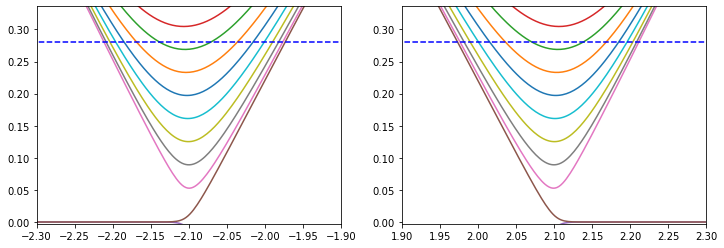

In [ ]:
# Define honeycomb lattice using parameters from the params dictionary
lat_constant = params['lat_constant']
lat = kwant.lattice.honeycomb(a=lat_constant, norbs=1, name=["a", "b"])
a, b = lat.sublattices  # Get the two sublattices (A and B) of graphene

# Create and finalize the system with zigzag boundaries
sys_to_study = make_system(length=Lx, width=Ly, boundary='zigzag')
syst = sys_to_study['system']  # Main scattering region
syst_final = syst.finalized()  # Finalize the system for calculations
flead = sys_to_study['lead'].finalized()  # Finalized lead for band structure

def plot_bands(energy, ax, interval=(-2.3, -1.9)):
    """
    Plot the band structure within specified momentum interval
    
    Args:
        energy: Reference energy to mark (in eV)
        ax: Matplotlib axis object to plot on
        interval: Tuple of (k_min, k_max) for momentum range
    """
    # Calculate and plot bands in specified momentum range
    kwant.plotter.bands(flead, ax=ax, momenta=np.linspace(*interval, 160), params=params)
    
    # Set plot limits
    ax.set_xlim(*interval)
    ax.set_ylim(-0.01*energy, 1.2*energy)  # Set y-axis around reference energy
    
    # Mark the reference energy level
    ax.axhline(y=energy, linestyle="--", color="b")

# Create figure with two panels for valence and conduction bands
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot valence band region (negative k-values)
plot_bands(energy=0.28, ax=axes[0], interval=(-2.3, -1.9))

# Plot conduction band region (positive k-values)
plot_bands(energy=0.28, ax=axes[1], interval=(1.9, 2.3))

plt.show()

### Load calculated data for maps. Check file Map_generation.py for the detailed calculations

In [ ]:
# Load current data
currentsC = np.load('currentC_map.npy')  # Charge currents
currentsV = np.load('currentV_map.npy')  # Valley currents

# Map Visuizations

0
1
2
3


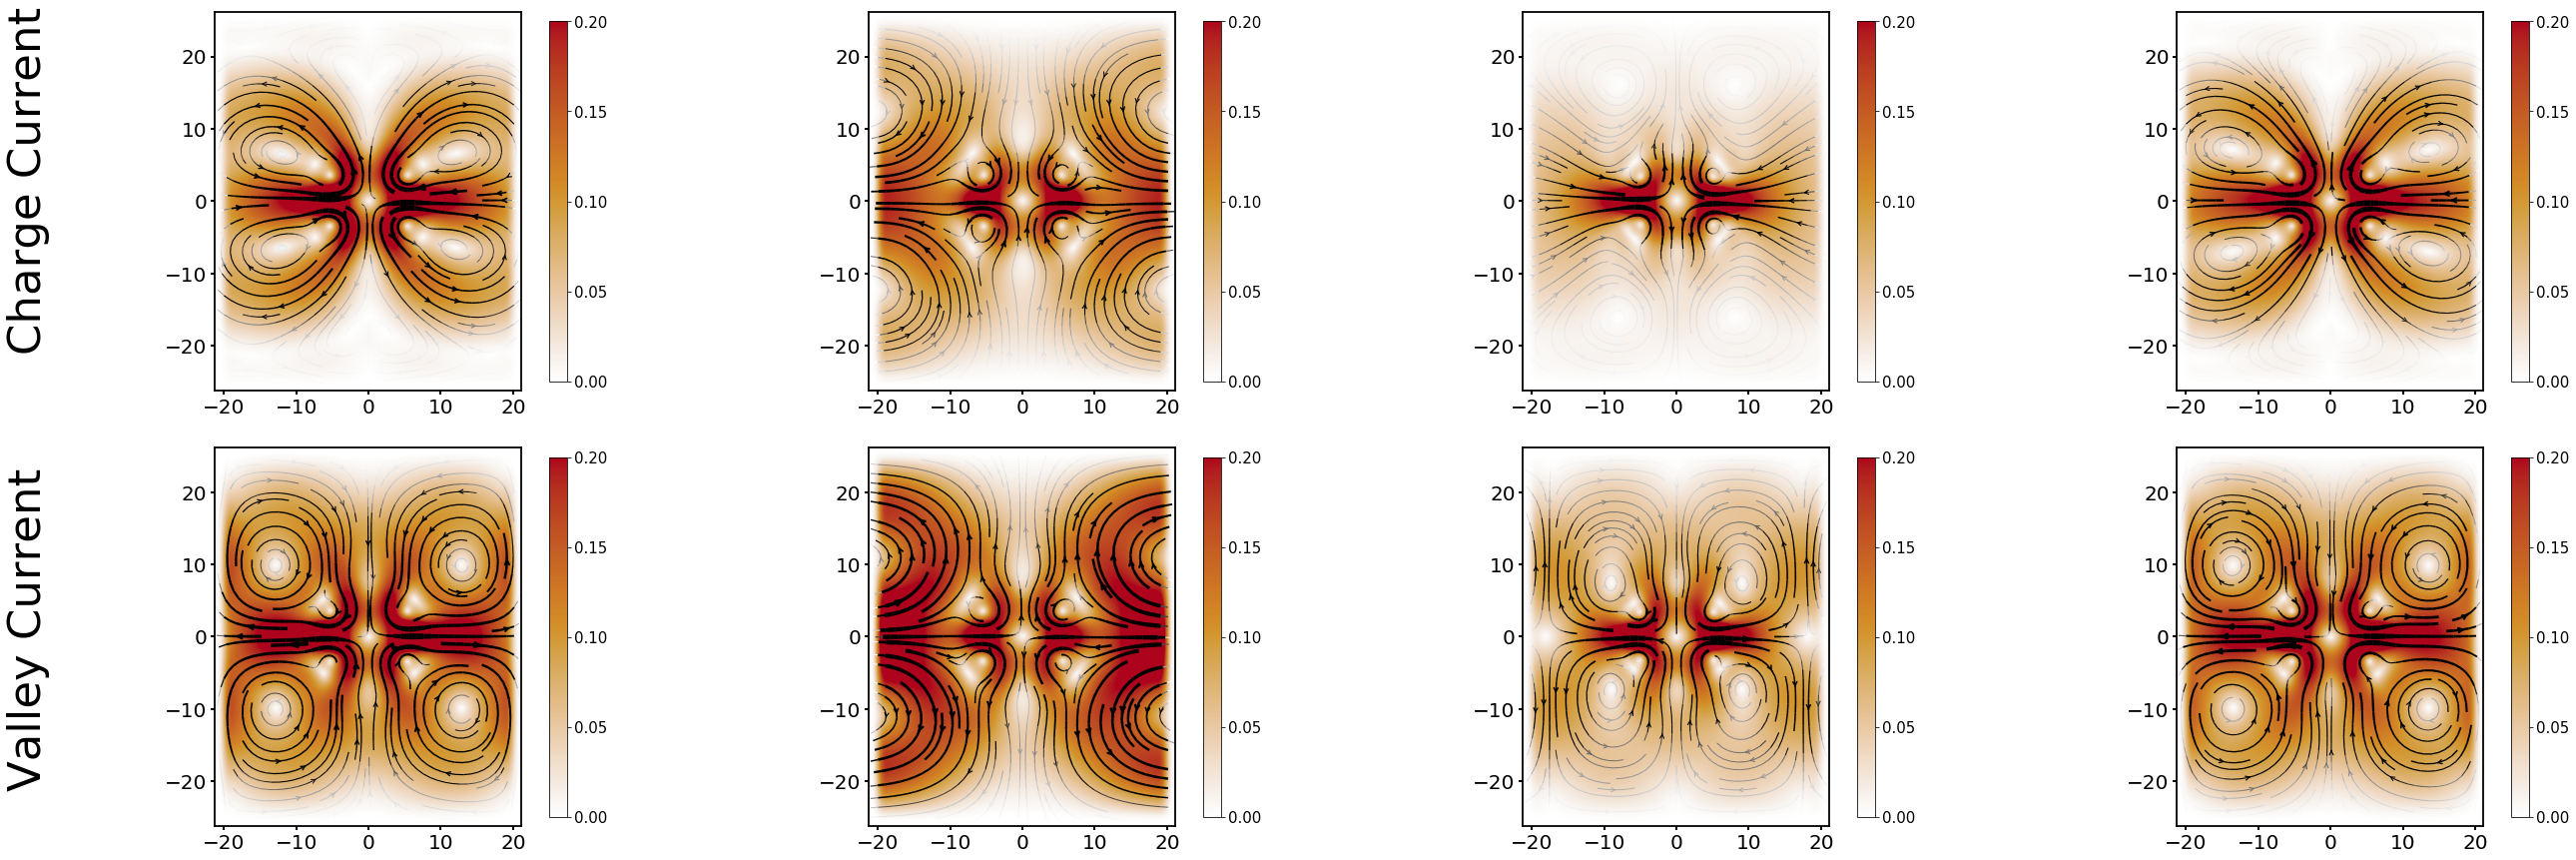

In [ ]:

# Create figure with subplots (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(45, 15))

# Time indices to plot
time_indices = [0, 1, 2, 3]  # Indices corresponding to specific time steps

# Plot settings
current_vmax = 0.2  # Maximum value for color scaling
cbar_ticks = [0, 0.05, 0.1, 0.15, 0.2]  # Colorbar tick positions
font_size = 45  # Base font size for labels

# Plot charge and valley currents for each time index
for n in range(4):
    for m in range(2):
        # Configure axis appearance
        ax = axes[m][n]
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_linewidth(1.8)
        ax.tick_params(colors='k', length=4, width=2, labelsize=20)
        ax.locator_params(axis='both', nbins=6)
    
    # Plot charge current (top row)
    kwant.plotter.current(syst_final, currentsC[time_indices[n]], 
                         vmax=current_vmax, ax=axes[0][n])
    
    # Plot valley current (bottom row)
    kwant.plotter.current(syst_final, currentsV[time_indices[n]], 
                         vmax=current_vmax, ax=axes[1][n])
    
    # Add colorbars
    for m in range(2):
        cb = plt.colorbar(axes[m][n].get_children()[-2], ax=axes[m][n], 
                         anchor=(0, 0.3), shrink=0.95, ticks=cbar_ticks)
        cb.ax.tick_params(labelsize=15)

# Add row labels
axes[0][0].text(-50, -20, 'Charge Current', fontsize=font_size, 
                rotation=90, bbox={'facecolor': 'red', 'alpha': 0, 'pad': 10})
axes[1][0].text(-50, -20, 'Valley Current', fontsize=font_size, 
                rotation=90, bbox={'facecolor': 'red', 'alpha': 0, 'pad': 10})

# Adjust layout and display
plt.subplots_adjust(hspace=0.15)
plt.show()

# Plotting Pumped Currents

In [ ]:
# Note: The current data files (currentK_edge.npy, currentK_prime_edge.npy, 
# currentC_edge.npy, currentV_edge.npy) were computed on a high-performance 
# computing cluster. These results were generated using large-scale numerical 
# simulations that required the parallel processing capabilities of a supercomputer.
#
# Simulation Parameters:
# - Time domain: 0 to 4000 (arbitrary units)
# - Time steps: 800 points (uniformly spaced)
# - Data represents edge currents in the system
#
# The raw computed currents have been loaded and assigned to working variables:
# currentK0, currentK_prime0 -> Valley currents (K and K' points)
# currentsC0, currentsV0 -> Charge and valley currents

currentK0 = np.load('currentK_edge.npy')
currentK_prime0 = np.load('currentK_prime_edge.npy')
currentsC0 = np.load('currentC_edge.npy')
currentsV0 = np.load('currentV_edge.npy')

# Assign to working variables
currentK = currentK0
currentK_prime = currentK_prime0
currentsC = currentsC0
currentsV = currentsV0

# Create corresponding time array
times = np.linspace(0, 4000, 800)

(-25, 25)

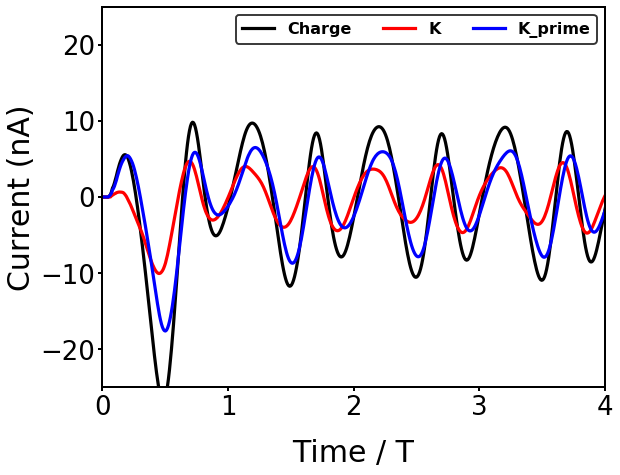

In [ ]:
# ==============================================
# Configuration Parameters
# ==============================================
PLOT_SIZE = (9, 7)                # Figure size in inches
LINE_WIDTH = 3.2                   # Plot line width
FONT_SIZE_LABELS = 30              # Axis label font size
FONT_SIZE_LEGEND = 16              # Legend font size
FONT_SIZE_TICKS = 23               # Tick label font size
SPINE_WIDTH = 2                    # Axis spine width
TICK_WIDTH = 2                     # Tick line width
TICK_LENGTH = 4                    # Tick length
X_LIMITS = (0, 4)                  # X-axis range
Y_LIMITS = (-25, 25)               # Y-axis range
SCALING_FACTOR = 9                 # Current scaling factor
TIME_NORMALIZATION = (2 * np.pi) / 0.01  # Time normalization factor

# ==============================================
# Data Preparation
# ==============================================
# Create figure with specified size
fig, ax = plt.subplots(figsize=PLOT_SIZE)

# Scale currents by factor of 9
currents_charge = [current * SCALING_FACTOR for current in currentsC]
currents_K = [current * SCALING_FACTOR for current in currentK]
currents_K_prime = [current * SCALING_FACTOR for current in currentK_prime]

# Normalize time by period T
normalized_times = np.array(times) / TIME_NORMALIZATION

# ==============================================
# Plot Configuration
# ==============================================
# Plot the three current components
ax.plot(normalized_times, currents_charge, 'k-', 
        linewidth=LINE_WIDTH, label='Charge current')
ax.plot(normalized_times, currents_K, 'r-', 
        linewidth=LINE_WIDTH, label='K current')
ax.plot(normalized_times, currents_K_prime, 'b-', 
        linewidth=LINE_WIDTH, label='K\' current')

# Configure legend
legend_font = {'weight': 'bold', 'size': FONT_SIZE_LEGEND}
legend = ax.legend(['Charge', 'K', 'K\''], loc='best', ncol=3,
                  markerscale=0.8, labelspacing=1.5, prop=legend_font)
legend.get_frame().set_edgecolor('k')
legend.get_frame().set_linewidth(1.9)

# Axis labels
ax.set_xlabel('Time / T', fontsize=FONT_SIZE_LABELS, labelpad=18)
ax.set_ylabel('Current (nA)', fontsize=FONT_SIZE_LABELS)

# Tick parameters
ax.tick_params(colors='k', length=TICK_LENGTH, width=TICK_WIDTH, 
               labelsize=FONT_SIZE_TICKS)
ax.locator_params(axis='x', nbins=4)
ax.locator_params(axis='y', nbins=5)

# Axis spines formatting
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(SPINE_WIDTH)

# Set axis limits
ax.set_xlim(*X_LIMITS)
ax.set_ylim(*Y_LIMITS)

# Display Plot
plt.tight_layout()
plt.show()